# How to store analysis results in BigQuery and Cloud Storage

In this notebook we use public data to perform a simplistic analysis, storing the resulting image file of the plot to Cloud Storage and derivied data as a BigQuery table.

See also the companion Terra Support article [Accessing Advanced GCP features in Terra](https://support.terra.bio/hc/en-us/articles/360051229072-Accessing-Advanced-GCP-features-in-Terra).

The steps in this notebook are:

1. Installs extra dependencies.
1. Imports dependencies.
1. Sets a few global variables.
1. Performs any needed configuration.
1. Pulls some public data from BigQuery.
1. Plots the data.
1. Writes the resulting image file to Cloud Storage.
1. Write a subset of the dataframe to BigQuery as a new table.

# Setup

In [1]:
import os
import pandas as pd
import plotnine
from plotnine import *
import tensorflow as tf
import time

In [2]:
# Set a default plot size.
plotnine.options.figure_size = (10, 6)

## If you want this notebook to create output . . .

. . . edit these global variables in your clone of this notebook to WRITE data to your native Google Cloud Platform project.
* The destination Cloud Storage bucket and BigQuery dataset should already exist. Your pet account must have WRITE access to both.
* The remaining cells can be run as-is.

Otherwise, just ignore the errors that occur for the Cloud Storage and BigQuery code cells that write data to those locations.

In [3]:
# CHANGE THESE VARIABLES
PROJECT_ID = 'ah-native-gcp-project-74939'
BUCKET = 'gs://ah-native-gcp-project-74939-autodelete-after-one-day'
BQ_DATASET = 'BQ_dataset_autodelete_after_one_day'

# Analyze public data

## Load data from BigQuery

In [4]:
df = pd.io.gbq.read_gbq('''
  SELECT
    *
  FROM
    `genomics-public-data.1000_genomes.sample_info`
''')

df.shape

(3500, 62)

In [5]:
df.head()

,Sample,Family_ID,Population,Population_Description,Gender,Relationship,Unexpected_Parent_Child,Non_Paternity,Siblings,Grandparents,...,In_Final_Phase_Variant_Calling,Has_Omni_Genotypes,Has_Axiom_Genotypes,Has_Affy_6_0_Genotypes,Has_Exome_LOF_Genotypes,EBV_Coverage,DNA_Source_from_Coriell,Has_Sequence_from_Blood_in_Index,Super_Population,Super_Population_Description
0,HG00144,GBR001,GBR,British in England and Scotland,female,mother,HG00155,,,,...,None,None,None,None,None,NaN,,None,EUR,European
1,HG00147,GBR002a,GBR,British in England and Scotland,female,child,,,HG00146,,...,None,None,None,None,None,NaN,,None,EUR,European
2,HG00153,GBR003,GBR,British in England and Scotland,female,child,,,,,...,None,True,None,None,True,NaN,,None,EUR,European
3,HG00248,GBR004,GBR,British in England and Scotland,female,child,HG00247,,,,...,None,None,None,None,None,NaN,,None,EUR,European
4,HG00377,HG00377,FIN,Finnish in Finland,female,,,,,,...,None,True,None,None,True,NaN,,None,EUR,European


## Plot the data

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 820 rows containing non-finite values.


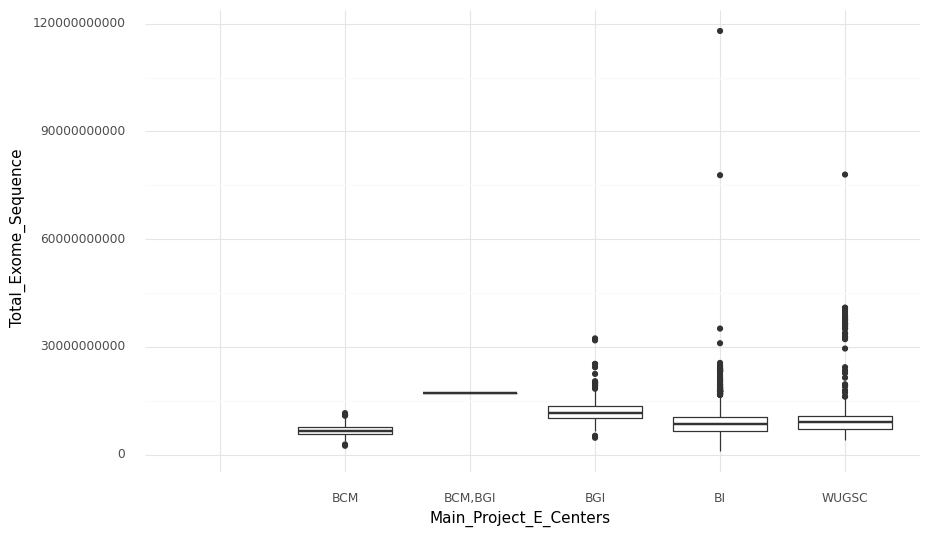

<ggplot: (8745751412829)>

In [6]:
p = (ggplot(df, aes(x='Main_Project_E_Centers', y='Total_Exome_Sequence')) +
 geom_boxplot() +
 theme_minimal()
)
p

## Save the plot to Cloud Storage

In [7]:
filename = 'plot-from-terra-' + time.strftime("%Y%m%d-%H%M%S") + '.png'
with tf.io.gfile.GFile(os.path.join(BUCKET, filename), 'w') as f:
  p.save(f, format='png', dpi=150)

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 6 in image.
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: <tensorflow.python.platform.gfile.GFile object at 0x7f447c6c4150>
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 820 rows containing non-finite values.


Fix the content type on the images so that we can view them directly in the Cloud Console.

In [8]:
!gsutil -m setmeta -h 'Content-Type:image/png' $BUCKET/$filename

Setting metadata on gs://ah-native-gcp-project-74939-autodelete-after-one-day/plot-from-terra-20210519-232237.png...
/ [1/1 objects] 100% Done                                                       
Operation completed over 1 objects.                                              


In [9]:
print(f"""
       The plot image can now be viewed at 
       https://console.cloud.google.com/storage/browser/{BUCKET[len('gs://'):]}?project={PROJECT_ID}
       """)


       The plot image can now be viewed at 
       https://console.cloud.google.com/storage/browser/ah-native-gcp-project-74939-autodelete-after-one-day?project=ah-native-gcp-project-74939
       


## Write the dataframe to BigQuery

In [10]:
df.iloc[:,0:10].to_gbq(
    '.'.join([BQ_DATASET, 'dataframe_from_terra_' + time.strftime("%Y%m%d_%H%M%S")]),
    project_id=PROJECT_ID)

1it [00:02,  2.56s/it]


In [12]:
print(f"""
       The the BigQuery table can now be viewed at
       https://console.cloud.google.com/bigquery?project={PROJECT_ID}
       """)


       The the BigQuery table can now be viewed at
       https://console.cloud.google.com/bigquery?project=ah-native-gcp-project-74939
       


# Provenance

In [13]:
import datetime
print(datetime.datetime.now())

2021-05-19 23:22:50.367637


In [14]:
!pip3 freeze

absl-py==0.12.0
anyio==3.1.0
argon2-cffi==20.1.0
arrow==1.1.0
arviz==0.11.2
asn1crypto==0.24.0
astroid==2.5.6
astunparse==1.6.3
async-generator==1.10
attrs==21.2.0
backcall==0.2.0
bagit==1.8.1
bgzip==0.3.5
binaryornot==0.4.4
biopython==1.78
bleach==3.3.0
bokeh==2.3.1
brewer2mpl==1.4.1
bx-python==0.8.11
CacheControl==0.11.7
cachetools==4.2.2
certifi==2020.12.5
cffi==1.14.5
cftime==1.4.1
chardet==4.0.0
cli-builder==0.1.5
click==7.1.2
colorama==0.4.4
confuse==1.4.0
cookiecutter==1.7.2
crcmod==1.7
cryptography==3.4.7
cwltool==1.0.20190228155703
cycler==0.10.0
Cython==0.29.23
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
entrypoints==0.3
facets-overview==1.0.0
fastinterval==0.1.1
fastprogress==1.0.0
filelock==3.0.12
firecloud==0.16.25
flatbuffers==1.12
future==0.18.2
gast==0.3.3
ggplot==0.11.5
gitdb==4.0.7
GitPython==3.1.17
google-api-core==1.26.3
google-auth==1.30.0
google-auth-oauthlib==0.4.4
google-cloud-bigquery==2.15.0
google-cloud-bigquery-datatransfer==3.1.1
google-

Copyright 2018 The Broad Institute, Inc., Verily Life Sciences, LLC All rights reserved.

This software may be modified and distributed under the terms of the BSD license. See the LICENSE file for details.